In [1]:
# Imports
import ee
import csv
import sys
import geemap
import rasterio 
import google.auth
import numpy as np
import pandas as pd
from lxml import etree
from io import StringIO
# from google.colab import auth
from google.cloud import storage
from IPython.display import clear_output
from google.auth.exceptions import RefreshError
from google.auth.transport.requests import Request
from offshore_methane import utils

# auth.authenticate_user()

credentials, std_proj = google.auth.default(scopes=['https://www.googleapis.com/auth/cloud-platform'])

ee.Authenticate()
ee.Initialize(project = 'skytruth-tech')

/Users/brendanjarrell/miniconda3/envs/methane/lib/python3.13/site-packages/geemap/conversion.py:23: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [6]:
test_aoi = (ee.Geometry.Polygon(
        [[[-92.80360717773439, 19.18247337142066],
          [-92.80360717773439, 19.07737953762038],
          [-92.69511718750002, 19.07737953762038],
          [-92.69511718750002, 19.18247337142066]]]))

# Bring in a test image.
s2 = (ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
     .filterBounds(test_aoi)
     .filterDate('2023-05-01','2023-10-01')
     .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 5))
     .filter(ee.Filter.lt('MEAN_SOLAR_ZENITH_ANGLE', 20)).first())

s2Test = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED').filter(ee.Filter.eq('system:index',s2.get('system:index'))).first()

In [7]:
s2 = utils.calculateSunglint_alpha(s2)


In [ ]:
test_map = geemap.Map()

test_map.addLayer(s2Test,{'bands':['B4','B3','B2'],'min':0,'max':2000})
print('Sunglint alpha value: ', s2.get('glint_alpha').getInfo())
test_map

In [9]:
system_index = s2Test.get('system:index').getInfo()
projection_info = s2Test.select('B12').projection().getInfo()

transform = projection_info['transform']
crs = projection_info['crs']
transform[0] = 5000
transform[4] = -5000
transform

[5000, 0, 499980, 0, -5000, 2200020]

In [10]:
tile_ids = system_index.split('_')[2]

# These will be used to get our product of interest.
tile_num = tile_ids[1:3]
lat_band = tile_ids[3]
grid_square = tile_ids[4:]
product_uri = s2Test.get('PRODUCT_ID').getInfo()+'.SAFE'
granule_id = s2Test.get('GRANULE_ID').getInfo()

# Name of xml product to query, which holds metadata for solar angles.
# ex: gs://gcp-public-data-sentinel-2/L2/tiles/01/C/CV/S2B_MSIL2A_20181213T210519_N0211_R071_T01CCV_20181213T221546.SAFE/GRANULE/L2A_T01CCV_A009249_20181213T210519/MTD_TL.xml
file_id = f"L2/tiles/{tile_num}/{lat_band}/{grid_square}/{product_uri}/GRANULE/{granule_id}/MTD_TL.xml"

file_id

'L2/tiles/15/Q/WB/S2B_MSIL2A_20230505T163839_N0509_R126_T15QWB_20230505T203828.SAFE/GRANULE/L2A_T15QWB_A032184_20230505T165653/MTD_TL.xml'

# Working on section immediately below this.

In [11]:
client = storage.Client()
bucket_name = "gcp-public-data-sentinel-2"
bucket = client.get_bucket(bucket_name)

blob = bucket.blob(file_id)

glint_bytes = blob.download_as_bytes()

In [12]:
# create a XML parser to parse the metadata and retrieve its root
parser = etree.XMLParser(no_network=True, remove_blank_text=True)
root = etree.fromstring(glint_bytes, parser=parser)

root

<Element {https://psd-14.sentinel2.eo.esa.int/PSD/S2_PDI_Level-2A_Tile_Metadata.xsd}Level-2A_Tile_ID at 0x14af0dc80>

In [13]:
def get_grid_values_from_xml(tree_node, xpath_str):
    '''Receives a XML tree node and a XPath parsing string and search for children matching the string.
       Then, extract the VALUES in <values> v1 v2 v3 </values> <values> v4 v5 v6 </values> format as numpy array
       Loop through the arrays to compute the mean.
    '''
    node_list = tree_node.xpath(xpath_str)

    arrays_lst = []
    for node in node_list:
        values_lst = node.xpath('.//VALUES/text()')
        values_arr = np.array(list(map(lambda x: x.split(' '), values_lst))).astype('float')
        arrays_lst.append(values_arr)

    return np.nanmean(arrays_lst, axis=0)

In [14]:
sun_zenith = get_grid_values_from_xml(root, './/Sun_Angles_Grid/Zenith')
sun_azimuth = get_grid_values_from_xml(root, './/Sun_Angles_Grid/Azimuth')

view_zenith = get_grid_values_from_xml(root, './/Viewing_Incidence_Angles_Grids/Zenith')
view_azimuth = get_grid_values_from_xml(root, './/Viewing_Incidence_Angles_Grids/Azimuth')

In [15]:
pd.DataFrame(view_zenith).iloc[:5, :5], pd.DataFrame(view_azimuth).iloc[:5, :5]


(          0         1         2         3         4
 0  7.752360  8.149683  8.531838  8.914004  9.296081
 1  7.849552  8.238639  8.620812  9.002965  9.385002
 2  7.939098  8.327619  8.709797  9.091936  9.473933
 3  8.034498  8.416622  8.798796  9.180910  9.562862
 4  8.123488  8.505636  8.887806  9.269888  9.651788,
             0           1           2           3           4
 0  292.310154  273.790308  274.319308  274.804000  275.249385
 1  282.789192  273.917231  274.435308  274.910077  275.347231
 2  282.817154  274.041154  274.548538  275.014231  275.443385
 3  273.619077  274.162385  274.659538  275.116308  275.537077
 4  273.748923  274.280846  274.768231  275.216077  275.629462)

In [16]:
# convert angles arrays to radians
sun_zenith_rad = np.deg2rad(sun_zenith)
sun_azimuth_rad = np.deg2rad(sun_azimuth)

view_zenith_rad = np.deg2rad(view_zenith)
view_azimuth_rad = np.deg2rad(view_azimuth)

In [17]:
# calculate glint angle
phi = sun_azimuth_rad - view_azimuth_rad
Tetag = np.cos(view_zenith_rad) * np.cos(sun_zenith_rad) - np.sin(view_zenith_rad) * np.sin(sun_zenith_rad) * np.cos(phi)

In [18]:
# convert results to degrees
glint_array = np.degrees(np.arccos(Tetag))
glint_array[np.isnan(glint_array)] = -1

In [7]:
import matplotlib.pyplot as plt

def create_annotated_heatmap(hm, cmap='magma_r', vmin=None, vmax=None):
    '''Create an annotated heatmap. Parameter img is an optional background img to be blended'''
    fig, ax = plt.subplots(figsize=(15, 15))

    ax.imshow(hm, vmin=vmin, vmax=vmax, cmap=cmap)

    # Loop over data dimensions and create text annotations.
    for i in range(0, hm.shape[0]):
        for j in range(0, hm.shape[1]):
            text = ax.text(j, i, round(hm[i, j],2),
                           ha="center", va="center", color="cornflowerblue")

    return fig, ax


fig, ax = create_annotated_heatmap(glint_array)


NameError: name 'glint_array' is not defined

In [21]:
with rasterio.open(
    f'glint_{product_uri.split('.')[0]}.tif', 'w',
    driver='GTiff',
    height=glint_array.shape[0],
    width=glint_array.shape[1],
    count=1,
    dtype=glint_array.dtype,
    crs=crs,
    transform=transform
) as dst:
    dst.write(glint_array, 1)


In [22]:
from rio_cogeo.cogeo import cog_translate
from rio_cogeo import cog_profiles

def _translate(src_path, dst_path, profile="raw", profile_options={}, **options):
    """Convert image to COG."""
    # Format creation option (see gdalwarp `-co` option)
    output_profile = cog_profiles.get(profile)
    output_profile.update(dict(BIGTIFF="IF_SAFER"))
    output_profile.update(profile_options)

    # Dataset Open option (see gdalwarp `-oo` option)
    config = dict(
        GDAL_NUM_THREADS="ALL_CPUS",
        GDAL_TIFF_INTERNAL_MASK=True,
        GDAL_TIFF_OVR_BLOCKSIZE="256",
    )

    cog_translate(
        src_path,
        dst_path,
        output_profile,
        config=config,
        in_memory=False,
        quiet=True,
        **options,
    )
    return True

In [23]:
_translate('/Users/brendanjarrell/Documents/GitHub/offshore-methane/notebooks/glint_S2B_MSIL2A_20230505T163839_N0509_R126_T15QWB_20230505T203828.tif','/Users/brendanjarrell/Documents/GitHub/offshore-methane/notebooks/glint_S2B_MSIL2A_20230505T163839_N0509_R126_T15QWB_20230505T203828_cog.tif')

True

In [28]:
product_uri

'S2B_MSIL2A_20230505T163839_N0509_R126_T15QWB_20230505T203828.SAFE'

In [24]:
# Upload the image to Google Cloud Storage
from matplotlib import image


bucket_name = 'glint-images-s2'
# destination_blob_name = 'example.tif'
source_file_name = f'glint_{product_uri.split('.')[0]}_cog.tif'

bucket = client.bucket(bucket_name)
blob = bucket.blob(source_file_name)
blob.upload_from_filename(source_file_name)

print(f"File {source_file_name} uploaded to {bucket_name}.")

# Load the image into Google Earth Engine
gcs_image_url = f"gs://{bucket_name}/{source_file_name}"

File glint_S2B_MSIL2A_20230505T163839_N0509_R126_T15QWB_20230505T203828_cog.tif uploaded to glint-images-s2.


In [25]:
image = ee.Image.loadGeoTIFF(gcs_image_url)
print(image.getInfo())

{'type': 'Image', 'bands': [{'id': 'B0', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'dimensions': [23, 23], 'crs': 'EPSG:32615', 'crs_transform': [5000, 0, 499980, 0, -5000, 2200020]}]}


/var/folders/9v/x_rm5y652vnf054kd69_9s100000gn/T/ipykernel_24987/589416334.py:14: RuntimeWarning: Mean of empty slice
  return np.nanmean(arrays_lst, axis=0)


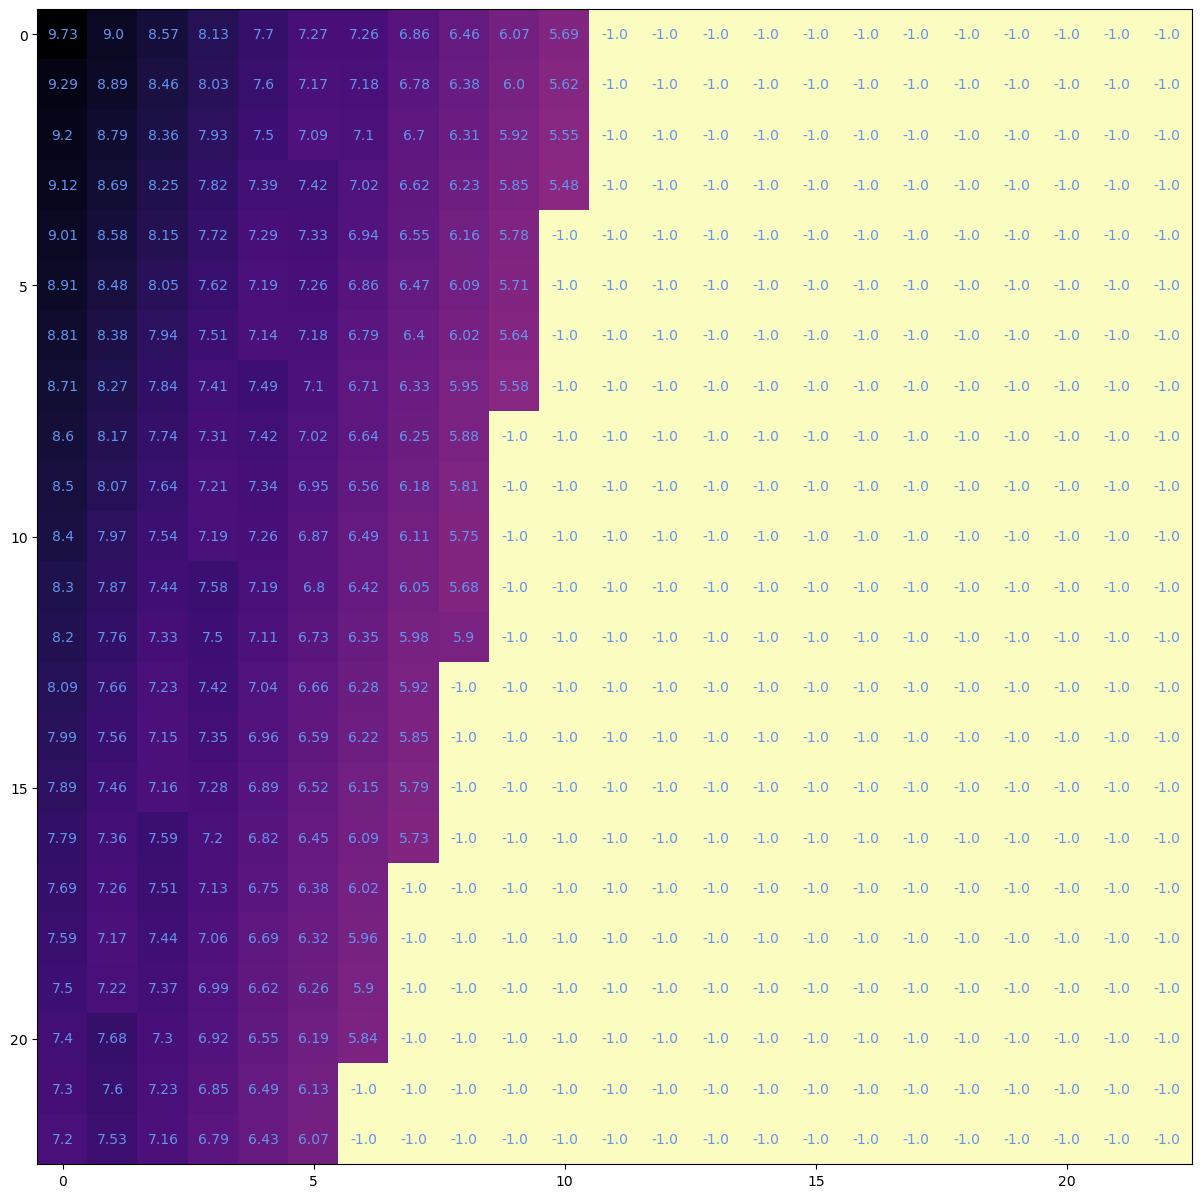

In [8]:
def get_grid_values_from_xml(tree_node, xpath_str):
    '''Receives a XML tree node and a XPath parsing string and search for children matching the string.
       Then, extract the VALUES in <values> v1 v2 v3 </values> <values> v4 v5 v6 </values> format as numpy array
       Loop through the arrays to compute the mean.
    '''
    node_list = tree_node.xpath(xpath_str)

    arrays_lst = []
    for node in node_list:
        values_lst = node.xpath('.//VALUES/text()')
        values_arr = np.array(list(map(lambda x: x.split(' '), values_lst))).astype('float')
        arrays_lst.append(values_arr)

    return np.nanmean(arrays_lst, axis=0)

# Creates a glint map that gets output to GCS.
# index expects a system:index.
# Ex: 20230505T163839_20230505T165653_T15QWB.
def create_sunglint_map_s2(index, out_bucket=None):

    # Load in image of interest.
    image = ee.Image(f'COPERNICUS/S2_HARMONIZED/{index}')

    # Find SR equivalent image.
    sr_img = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
             .filterBounds(image.geometry())
             .filter(ee.Filter.eq('system:index',index)).first())

    # Retireving information from the equivalent SR image.
    sr_index = sr_img.get('system:index').getInfo()
    projection_info = sr_img.select('B12').projection().getInfo()
    transform = projection_info['transform']
    crs = projection_info['crs']
    transform[0] = 5000
    transform[4] = -5000

    tile_ids = sr_index.split('_')[2]

    # These will be used to get our product of interest.
    tile_num = tile_ids[1:3]
    lat_band = tile_ids[3]
    grid_square = tile_ids[4:]
    product_uri = sr_img.get('PRODUCT_ID').getInfo()+'.SAFE'
    granule_id = sr_img.get('GRANULE_ID').getInfo()

    # Name of xml product to query, which holds metadata for solar angles.
    # ex: gs://gcp-public-data-sentinel-2/L2/tiles/01/C/CV/S2B_MSIL2A_20181213T210519_N0211_R071_T01CCV_20181213T221546.SAFE/GRANULE/L2A_T01CCV_A009249_20181213T210519/MTD_TL.xml
    file_id = f"L2/tiles/{tile_num}/{lat_band}/{grid_square}/{product_uri}/GRANULE/{granule_id}/MTD_TL.xml"


    client = storage.Client()
    s2_bucket = client.get_bucket("gcp-public-data-sentinel-2")
    blob = s2_bucket.blob(file_id)
    glint_bytes = blob.download_as_bytes()
    
    # create a XML parser to parse the metadata and retrieve its root
    parser = etree.XMLParser(no_network=True, remove_blank_text=True)
    root = etree.fromstring(glint_bytes, parser=parser)
    
    # Retrieve our angle rasters from the metadata.
    sun_zenith = get_grid_values_from_xml(root, './/Sun_Angles_Grid/Zenith')
    sun_azimuth = get_grid_values_from_xml(root, './/Sun_Angles_Grid/Azimuth')

    view_zenith = get_grid_values_from_xml(root, './/Viewing_Incidence_Angles_Grids/Zenith')
    view_azimuth = get_grid_values_from_xml(root, './/Viewing_Incidence_Angles_Grids/Azimuth')

    
    # convert angles arrays to radians
    theta_naught = np.deg2rad(sun_zenith)
    phi_naught = np.deg2rad(sun_azimuth)

    theta = np.deg2rad(view_zenith)
    phi = np.deg2rad(view_azimuth)

    # Step-by-step computation
    a = np.cos(theta_naught + theta) + np.cos(theta_naught - theta)
    b = np.cos(theta_naught + theta) - np.cos(theta_naught - theta)
    c = np.cos(phi_naught - phi)

    arg = (a + b * c) / 2.0
    alpha = np.arccos(arg)  # Resulting glint angle

    # convert results to degrees
    glint_array = np.degrees(alpha)
    glint_array[np.isnan(glint_array)] = -1

    return glint_array

test = create_sunglint_map_s2('20230505T163839_20230505T165653_T15QWB')

fig, ax = create_annotated_heatmap(test)